In [1]:
import numpy as np
from scipy import stats

import pymc3 as pm

import torch
import pyro
import pyro.infer as infer
import pyro.distributions as dist
from torch.distributions import constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import collections

In [3]:
colors = sns.color_palette().as_hex()
n_colors = len(colors)

In [4]:
seed = 100
np.random.seed(seed)

# 事前予測と事後予測

- 単純な二項分布のパラメータ推論
- 事前分布による予測と事後分布での予測

## 問題設定

二項分布のパラメータ推論問題。

## データ

In [5]:
k = 1
n = 15

## 推論（PyMC3）

### モデルの定義

In [6]:
with pm.Model() as model:
    theta = pm.Beta('theta', 1, 1)
    y = pm.Binomial('y', p=theta, n=n, observed=k)

### 推論

In [7]:
%%time
with model:
    trace = pm.sample(1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [theta]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 4 seconds.


CPU times: user 3.07 s, sys: 1.03 s, total: 4.1 s
Wall time: 7.19 s


### 推論結果の確認

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

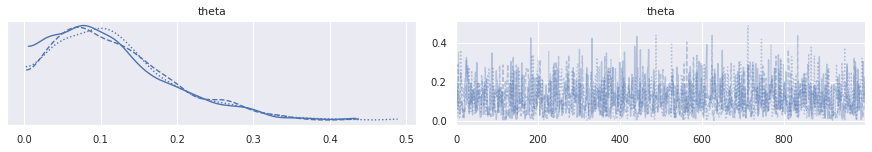

In [8]:
pm.traceplot(trace)

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'theta'}>], dtype=object)

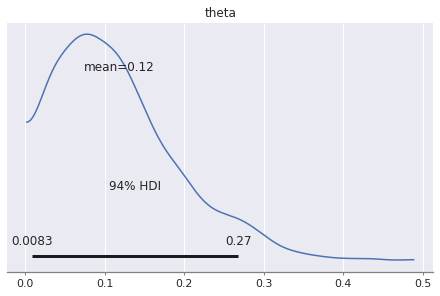

In [9]:
pm.plot_posterior(trace)

### 事前予測/事後予測

（すでに事後分布の推論をしてあるけど）事前分布に基づいてデータをサンプルする。

モデルの定義の中で、二項分布のパラメータ$\theta$の事前分布は一様分布であることにしているので、0からnまでの値が一様にサンプルされることが期待される。

In [10]:
with model:
    sample_pri = pm.sample_prior_predictive(samples=3000)

In [11]:
with model:
    sample_post = pm.sample_posterior_predictive(trace)

In [12]:
pri_count = collections.Counter(sample_pri['y'])
N_pri = sum(pri_count.values())
ks_pri = np.array(list(pri_count.keys()))
counts_pri = np.array(list(pri_count.values()))

post_count = collections.Counter(sample_post['y'])
N_post = sum(post_count.values())
ks_pos = np.array(list(post_count.keys()))
counts_pos = np.array(list(post_count.values()))

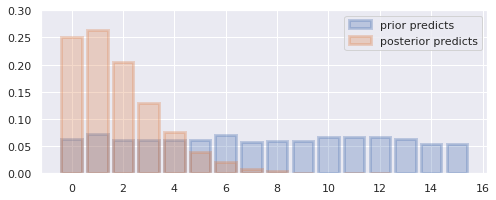

In [13]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)

ax.bar(ks_pri, counts_pri/N_pri, alpha=0.3, linewidth=3, edgecolor=colors[0], label='prior predicts')
ax.bar(ks_pos, counts_pos/N_post, alpha=0.3, linewidth=3, edgecolor=colors[1], label='posterior predicts')
ax.set_ylim(0., 0.3)
ax.legend()

## 推論（Pyro）


### モデル定義

In [14]:
def model_binom(params=None):
    theta = pyro.sample('theta', dist.Beta(torch.tensor(1.), torch.tensor(1.)))
    y = pyro.sample('y', dist.Binomial(total_count=n, probs=theta))
    return y

### 推論

In [15]:
cond_data = pyro.condition(
    model_binom, 
    data={'n':torch.tensor(n).float(), 
          'y':torch.tensor(k).float()})

In [16]:
nuts_kernel = infer.NUTS(cond_data, 
                         adapt_step_size=True, 
                         jit_compile=True, 
                         ignore_jit_warnings=True)
mcmc = infer.MCMC(nuts_kernel, 
                  num_samples=1000,
                  warmup_steps=500,
                  num_chains=1)

mcmc.run()

Sample: 100%|██████████| 1500/1500 [00:05, 263.78it/s, step size=9.67e-01, acc. prob=0.916]


### 推論結果の確認

In [17]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.12      0.08      0.10      0.01      0.22    442.07      1.00

Number of divergences: 0


<AxesSubplot:>

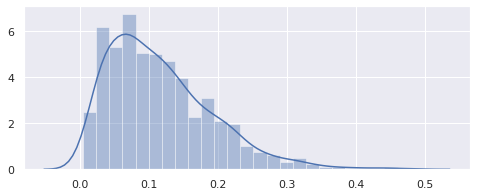

In [18]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)

theta_sample_mcmc = mcmc.get_samples()['theta']
sns.distplot(theta_sample_mcmc, ax=ax, label='theta')

### 事前予測／事後予測

事前分布からサンプルする。

事前分布では、二項分布のnだけを所与とし、サンプルを取得する。

In [19]:
cond_prior = pyro.condition(
    model_binom, 
    data={'n':torch.tensor(n).float()})

N_pri = 3000
prior_sample = [cond_prior().item() for i in range(N_pri)]
prior_sample_cnt = collections.Counter(prior_sample)

ks_pri = np.array(list(prior_sample_cnt.keys()))
counts_pri = np.array(list(prior_sample_cnt.values()))

事後分布からサンプルする。

$\theta$の事後分布からMCMCによってサンプルを取得しているため、このサンプルを使って$y$をサンプルする。

In [20]:
cond_post = pyro.condition(
    model_binom, 
    data={'n':torch.tensor(n).float(), 
          'theta':mcmc.get_samples()['theta']})
post_sample = cond_post()

N_pos = len(post_sample)
post_sample_cnt = collections.Counter(post_sample.numpy())
ks_pos = np.array(list(post_sample_cnt.keys()))
counts_pos = np.array(list(post_sample_cnt.values()))

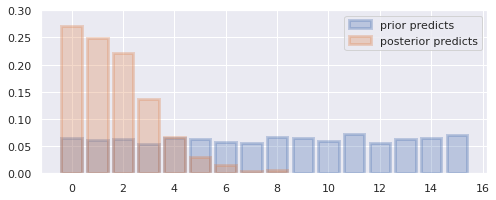

In [21]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)

#ax.bar(k_plots, counts/n_sample, label='prior predicts')
ax.bar(ks_pri, counts_pri/N_pri, 
       alpha=0.3, linewidth=3, edgecolor=colors[0], label='prior predicts')
ax.bar(ks_pos, counts_pos/N_pos, 
       alpha=0.3, linewidth=3, edgecolor=colors[1], label='posterior predicts')
ax.set_ylim(0., 0.3)
ax.legend()